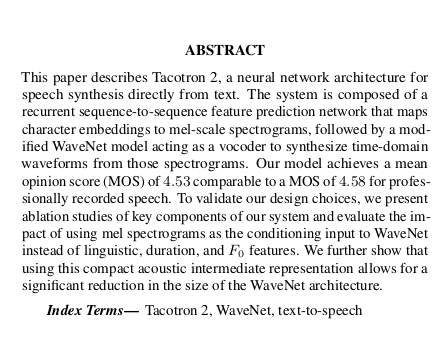

In [4]:
from IPython.display import Image
Image(filename='../images/tactron2.png')


In [5]:
## Try jeremy trick to convert these notebooks to folders


In [6]:
from math import sqrt
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
# from layers import ConvNorm, 

In [7]:
class LocationLayer(nn.Module):
    def __init__(self, attention_n_filters, attention_kernel_size,
                 attention_dim):
        super(LocationLayer, self).__init__()
        padding = int((attention_kernel_size - 1) / 2)
        self.location_conv = ConvNorm(2, attention_n_filters,
                                      kernel_size=attention_kernel_size,
                                      padding=padding, bias=False, stride=1,
                                      dilation=1)
        self.location_dense = LinearNorm(attention_n_filters, attention_dim,
                                         bias=False, w_init_gain='tanh')

    def forward(self, attention_weights_cat):
        processed_attention = self.location_conv(attention_weights_cat)
        processed_attention = processed_attention.transpose(1, 2)
        processed_attention = self.location_dense(processed_attention)
        return processed_attention

### Attention

In [8]:
class Attention(nn.Module):
    def __init__(self, attention_rnn_dim, embedding_dim, attention_dim,
                 attention_location_n_filters, attention_location_kernel_size):
        super(Attention, self).__init__()
        self.query_layer = LinearNorm(attention_rnn_dim, attention_dim,
                                      bias=False, w_init_gain='tanh')
        self.memory_layer = LinearNorm(embedding_dim, attention_dim, bias=False,
                                       w_init_gain='tanh')
        self.v = LinearNorm(attention_dim, 1, bias=False)
        self.location_layer = LocationLayer(attention_location_n_filters,
                                            attention_location_kernel_size,
                                            attention_dim)
        self.score_mask_value = -float("inf")

    def get_alignment_energies(self, query, processed_memory,
                               attention_weights_cat):

        processed_query = self.query_layer(query.unsqueeze(1))
        processed_attention_weights = self.location_layer(attention_weights_cat)
        energies = self.v(torch.tanh(
            processed_query + processed_attention_weights + processed_memory))

        energies = energies.squeeze(-1)
        return energies

    def forward(self, attention_hidden_state, memory, processed_memory,
                attention_weights_cat, mask):
        alignment = self.get_alignment_energies(
            attention_hidden_state, processed_memory, attention_weights_cat)

        if mask is not None:
            alignment.data.masked_fill_(mask, self.score_mask_value)

        attention_weights = F.softmax(alignment, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights

In [9]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x


In [10]:
class Postnet(nn.Module):
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self, hparams):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                
                (hparams.n_mel_channels, hparams.postnet_embedding_dim,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(hparams.postnet_embedding_dim))
        )

        for i in range(1, hparams.postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(hparams.postnet_embedding_dim,
                             hparams.postnet_embedding_dim,
                             kernel_size=hparams.postnet_kernel_size, stride=1,
                             padding=int((hparams.postnet_kernel_size - 1) / 2),
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(hparams.postnet_embedding_dim))
            )

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(hparams.postnet_embedding_dim, hparams.n_mel_channels,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(hparams.n_mel_channels))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

        return x


### Encoder


In [11]:
class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=hparams.encoder_kernel_size, stride=1,
                         padding=int((hparams.encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(hparams.encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                            int(hparams.encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(
            x, input_lengths, batch_first=True)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(
            outputs, batch_first=True)

        return outputs

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs


### Decoder

In [12]:
print(f"Hello WorlOd")

Hello WorlOd


In [13]:
class Decoder(nn.Module):
    def __init__(self, hparams):
        super(Decoder, self).__init__()
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.encoder_embedding_dim = hparams.encoder_embedding_dim
        self.attention_rnn_dim = hparams.attention_rnn_dim
        self.decoder_rnn_dim = hparams.decoder_rnn_dim
        self.prenet_dim = hparams.prenet_dim
        self.max_decoder_steps = hparams.max_decoder_steps
        self.gate_threshold = hparams.gate_threshold
        self.p_attention_dropout = hparams.p_attention_dropout
        self.p_decoder_dropout = hparams.p_decoder_dropout

        self.prenet = Prenet(
            hparams.n_mel_channels * hparams.n_frames_per_step,
            [hparams.prenet_dim, hparams.prenet_dim])

        self.attention_rnn = nn.LSTMCell(
            hparams.prenet_dim + hparams.encoder_embedding_dim,
            hparams.attention_rnn_dim)

        self.attention_layer = Attention(
            hparams.attention_rnn_dim, hparams.encoder_embedding_dim,
            hparams.attention_dim, hparams.attention_location_n_filters,
            hparams.attention_location_kernel_size)

        self.decoder_rnn = nn.LSTMCell(
            hparams.attention_rnn_dim + hparams.encoder_embedding_dim,
            hparams.decoder_rnn_dim, 1)

        self.linear_projection = LinearNorm(
            hparams.decoder_rnn_dim + hparams.encoder_embedding_dim,
            hparams.n_mel_channels * hparams.n_frames_per_step)

        self.gate_layer = LinearNorm(
            hparams.decoder_rnn_dim + hparams.encoder_embedding_dim, 1,
            bias=True, w_init_gain='sigmoid')

    def get_go_frame(self, memory):
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(
            B, self.n_mel_channels * self.n_frames_per_step).zero_())
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())
        self.attention_cell = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())

        self.decoder_hidden = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())
        self.decoder_cell = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())

        self.attention_weights = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_weights_cum = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_context = Variable(memory.data.new(
            B, self.encoder_embedding_dim).zero_())

        self.memory = memory
        self.processed_memory = self.attention_layer.memory_layer(memory)
        self.mask = mask

    def parse_decoder_inputs(self, decoder_inputs):
        # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(1, 2)
        decoder_inputs = decoder_inputs.view(
            decoder_inputs.size(0),
            int(decoder_inputs.size(1)/self.n_frames_per_step), -1)
        # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(0, 1)
        return decoder_inputs

    def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
        # (T_out, B) -> (B, T_out)
        alignments = torch.stack(alignments).transpose(0, 1)
        # (T_out, B) -> (B, T_out)
        gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
        gate_outputs = gate_outputs.contiguous()
        # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
        mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
        # decouple frames per step
        mel_outputs = mel_outputs.view(
            mel_outputs.size(0), -1, self.n_mel_channels)
        # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
        mel_outputs = mel_outputs.transpose(1, 2)

        return mel_outputs, gate_outputs, alignments

    def decode(self, decoder_input):
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training)

        attention_weights_cat = torch.cat(
            (self.attention_weights.unsqueeze(1),
             self.attention_weights_cum.unsqueeze(1)), dim=1)
        self.attention_context, self.attention_weights = self.attention_layer(
            self.attention_hidden, self.memory, self.processed_memory,
            attention_weights_cat, self.mask)

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat(
            (self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training)

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1)
        decoder_output = self.linear_projection(
            decoder_hidden_attention_context)

        gate_prediction = self.gate_layer(decoder_hidden_attention_context)
        return decoder_output, gate_prediction, self.attention_weights

    def forward(self, memory, decoder_inputs, memory_lengths):

        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths))

        mel_outputs, gate_outputs, alignments = [], [], []
        while len(mel_outputs) < decoder_inputs.size(0) - 1:
            decoder_input = decoder_inputs[len(mel_outputs)]
            mel_output, gate_output, attention_weights = self.decode(
                decoder_input)
            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output.squeeze(1)]
            alignments += [attention_weights]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments

    def inference(self, memory):
        """ Decoder inference
        PARAMS
        ------
        memory: Encoder outputs
        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output]
            alignments += [alignment]

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments

In [14]:
class PostNet(nn.Module):
    def __init__(self, mel_dim, num_convs=5):
        super(PostNet, self).__init__()
        self.convolutions = nn.ModuleList()
        self.convolutions.append(
            ConvBNBlock(mel_dim, 512, kernel_size=5, nonlinear='tanh'))
        for _ in range(1, num_convs-1):
            self.convolutions.append(
            ConvBNBlock(512, 512, kernel_size=5, nonlinear='tanh'))
            self.convolutions.append(
                ConvBNBlock(512, mel_dim, kernel_size=5, nonlinear='tanh'))
            
    def forward(self, x):
        for layer in self.convolutions:
            x=layer(x)
        return x

### Tactron architecture

In [ ]:
# class Tacotron2(nn.Module):
#     def __init__(self, hparams):
#         super(Tacotron2, self).__init__()
#         self.mask_padding = hparams.mask_padding
#         self.fp16_run = hparams.fp16_run
#         self.n_mel_channels = hparams.n_mel_channels
#         self.n_frames_per_step = hparams.n_frames_per_step
#         self.embedding = nn.Embedding(
#             hparams.n_symbols, hparams.symbols_embedding_dim)
#         std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
#         val = sqrt(3.0) * std  # uniform bounds for std
#         self.embedding.weight.data.uniform_(-val, val)
#         self.encoder = Encoder(hparams)
#         self.decoder = Decoder(hparams)
#         self.postnet = Postnet(hparams)

#     def parse_batch(self, batch):
#         text_padded, input_lengths, mel_padded, gate_padded, \
#             output_lengths = batch
#         text_padded = to_gpu(text_padded).long()
#         input_lengths = to_gpu(input_lengths).long()
#         max_len = torch.max(input_lengths.data).item()
#         mel_padded = to_gpu(mel_padded).float()
#         gate_padded = to_gpu(gate_padded).float()
#         output_lengths = to_gpu(output_lengths).long()

#         return (
#             (text_padded, input_lengths, mel_padded, max_len, output_lengths),
#             (mel_padded, gate_padded))

#     def parse_output(self, outputs, output_lengths=None):
#         if self.mask_padding and output_lengths is not None:
#             mask = ~get_mask_from_lengths(output_lengths)
#             mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
#             mask = mask.permute(1, 0, 2)

#             outputs[0].data.masked_fill_(mask, 0.0)
#             outputs[1].data.masked_fill_(mask, 0.0)
#             outputs[2].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

#         return outputs

#     def forward(self, inputs):
#         text_inputs, text_lengths, mels, max_len, output_lengths = inputs
#         text_lengths, output_lengths = text_lengths.data, output_lengths.data

#         embedded_inputs = self.embedding(text_inputs).transpose(1, 2)

#         encoder_outputs = self.encoder(embedded_inputs, text_lengths)

#         mel_outputs, gate_outputs, alignments = self.decoder(
#             encoder_outputs, mels, memory_lengths=text_lengths)

#         mel_outputs_postnet = self.postnet(mel_outputs)
#         mel_outputs_postnet = mel_outputs + mel_outputs_postnet

#         return self.parse_output(
#             [mel_outputs, mel_outputs_postnet, gate_outputs, alignments],
#             output_lengths)

#     def inference(self, inputs):
#         embedded_inputs = self.embedding(inputs).transpose(1, 2)
#         encoder_outputs = self.encoder.inference(embedded_inputs)
#         mel_outputs, gate_outputs, alignments = self.decoder.inference(
#             encoder_outputs)

#         mel_outputs_postnet = self.postnet(mel_outputs)
#         mel_outputs_postnet = mel_outputs + mel_outputs_postnet

#         outputs = self.parse_output(
#             [mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

#         return outputs